In [2]:
from typing import Callable, List, Tuple

import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch import nn
from torch.distributions.distribution import Distribution
from pytorch_lightning.loggers import TensorBoardLogger

In [3]:
def set_random_seed(seed):
    torch.manual_seed(seed)




In [4]:
class AffineCouplingLayer(nn.Module):
    def __init__(
        self,
        theta: nn.Module,
        split: Callable[[torch.Tensor], Tuple[torch.Tensor, torch.Tensor]],
        swap: int
    ):
        super().__init__()
        self.theta = theta
        self.split = split
        self.swap=swap

    def f(self, x: torch.Tensor) -> torch.Tensor:
        """f : x -> z. The inverse of g."""
        x2, x1 = self.split(x,self.swap)
        t, s = self.theta(x1)
        z1, z2 = x1, x2 * torch.exp(s) + t 
        log_det = s.sum(-1) 
        return torch.cat((z1, z2), dim=-1), log_det

    def g(self, z: torch.Tensor) -> torch.Tensor:
        """g : z -> x. The inverse of f."""
        z1, z2 = self.split(z,self.swap)
        t, s = self.theta(z1)
        x1, x2 = z1, (z2 - t) * torch.exp(-s)
        log_det = -s.sum(-1) 
        return torch.cat((x2, x1), dim=-1), log_det

In [17]:
class NormalizingFlow(nn.Module):
    def __init__(self, latent: Distribution, flows: List[nn.Module]):
        super().__init__()
        self.latent = latent
        self.flows = flows

    def latent_log_prob(self, z: torch.Tensor) -> torch.Tensor:
        llp=self.latent.log_prob(z)
        sum_llp= torch.sum(llp,axis=-1)
        return sum_llp

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        z=self.latent.sample((num_samples,))
        return z                  

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        """Sample a new observation x by sampling z from
        the latent distribution and pass through g."""
        z=self.latent_sample(num_samples)
        with torch.no_grad():
            x, _ = self.g(z)
        return x 
    

    def f(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:  #forward
        """Maps observation x to latent variable z.
        Additionally, computes the log determinant
        of the Jacobian for this transformation.
        Inveres of g."""
        z, sum_log_abs_det = x, torch.ones(x.size(0)).to(x.device)
        for flow in self.flows:
            z, log_abs_det = flow.f(z)
            sum_log_abs_det += log_abs_det

        return z, sum_log_abs_det

    def g(self, z: torch.Tensor) -> torch.Tensor:
        x, sum_log_abs_det = z, torch.ones(z.size(0)).to(z.device)
        for flow in reversed(self.flows):
            x, log_abs_det = flow.g(x)
            sum_log_abs_det += log_abs_det
        return x, sum_log_abs_det
    

    def g_steps(self, z: torch.Tensor) -> List[torch.Tensor]:
        """Maps latent variable z to observation x
        and stores intermediate results."""
        xs = [z]
        for flow in reversed(self.flows):
            xs.append(flow.g(xs[-1]))
        return xs
    
    def __len__(self) -> int:
        return len(self.flows)

In [18]:
class ThetaNetwork(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        num_hidden: int,
        hidden_dim: int,
        num_params: int,
    ):
        super().__init__()
        self.input = nn.Linear(in_dim, hidden_dim)
        self.hidden = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden)]
        )

        self.num_params = num_params
        self.out_dim = out_dim
        self.dims = nn.Linear(hidden_dim, out_dim * num_params)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.leaky_relu(self.input(x))
        for h in self.hidden:
            x = F.leaky_relu(h(x))

        batch_params = self.dims(x).reshape(x.size(0), self.out_dim, -1) 
        params = batch_params.chunk(self.num_params, dim=-1) #???
        return [p.squeeze(-1) for p in params]
    

In [19]:
def SplitFunc(x: torch.Tensor,swap: int) -> Tuple[torch.Tensor, torch.Tensor]:
    if swap==0:
        return x[:,::2], x[:,1::2]
    else: 
        return x[:,1::2], x[:,::2] 

In [20]:
from NFconstants import N_nod
from Data import normal_dist
def configure_theta():
    theta=ThetaNetwork(
                in_dim = N_nod//2,
                out_dim = N_nod//2,
                num_hidden = 4,  #2 to 6
                hidden_dim =100 , #100-1024
                num_params = 2)
    return theta
def configure_flows(n_flows):  # n_flows=8,...,12
    flows=[]
    for i in range(n_flows):
        flows.append(AffineCouplingLayer(configure_theta(),split=SplitFunc,swap=i%2))
    flows = nn.ModuleList(flows)
    return flows 
print(normal_dist)

                  

Normal(loc: torch.Size([10]), scale: torch.Size([10]))


In [21]:
class Pipeline(pl.LightningModule):
    def __init__(
        self,
        model,
        criterion,
        optimizer_class=torch.optim.Adam,
        optimizer_kwargs={"lr": 0.0001,"weight_decay": 0},
    ) -> None:
        super().__init__()
        self.model = model
        self.loss = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs


    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        z = batch
        x, log_abs_det = self.model.g(z)
        loss = self.loss(x,log_abs_det)
        self.log('train_loss', loss)
        return loss


    def on_train_epoch_end(self):
        #print("---------------------------end epoch---------------------------------")
        pass
    

In [22]:
from LOSS import KL_osc
from Data import train_loader

set_random_seed(42)
nf=NormalizingFlow(latent=normal_dist,flows=configure_flows(8))
pipeline=Pipeline(model=nf,criterion=KL_osc)
trainer = pl.Trainer(
    max_epochs=10,
    logger=TensorBoardLogger(save_dir=f"logs/nf"),
    num_sanity_val_steps=0,
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
torch.save(nf.state_dict(), "model_weights1.pth")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type            | Params
------------------------------------------
0 | model | NormalizingFlow | 336 K 
1 | loss  | KL_with_S       | 0     
------------------------------------------
336 K     Trainable params
0         Non-trainable params
336 K     Total params
1.344     Total estimated model params size (MB)
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


A Jupyter Widget

In [23]:
from Data import normal_dist
import numpy as np
from NFconstants import N_traj
NF_trained=NormalizingFlow(latent=normal_dist,flows=configure_flows(8))
NF_trained.load_state_dict(torch.load('model_weights1.pth'))
NF_trained.eval()
trajs=NF_trained.sample(N_traj)
trajs=trajs.numpy()
np.savetxt("nf_ensemble.txt",trajs,delimiter=",")

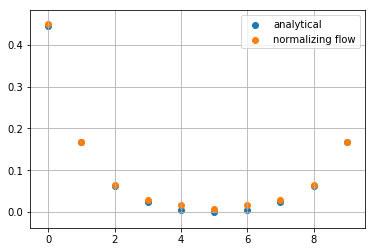

In [4]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from NFconstants import N_nod,N_traj, NG_points
from Value import G
import ensemble
from NFoscillator import basic_oscillator
from time import time



ens_nf=ensemble.ensemble.load("nf_ensemble.txt",basic_oscillator)
V_nf=np.vstack(ensemble.ensemble.Vaverage_and_sigma(ens_nf,G))
V_nft=V_nf.transpose()

ens=ensemble.ensemble.load("ensemble.txt",basic_oscillator)
V=np.vstack(ensemble.ensemble.Vaverage_and_sigma(ens,G))
Vt=V.transpose()


fig=plt.figure()
plt.scatter(list(range(NG_points)),Vt[0])
plt.scatter(list(range(NG_points)),V_nft[0])
plt.legend(["analytical","normalizing flow"])
plt.grid(True)
plt.show()



In [49]:
%reload_ext tensorboard
%tensorboard --logdir=logs/nf --port=6007

TypeError: _repr_pretty_() takes 1 positional argument but 3 were given

TypeError: _repr_pretty_() takes 1 positional argument but 3 were given